# Project 3 Supervised Learning

 Vanessa Hu
 
 Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines
 HOSTED BY DRIVENDATA: https://www.drivendata.org/competitions/66/flu-shot-learning/
 
***

Can you predict whether people got H1N1 and seasonal flu vaccines using information they shared about their backgrounds, opinions, and health behaviors?

In this challenge, we will take a look at vaccination, a key public health measure used to fight infectious diseases. Vaccines provide immunization for individuals, and enough immunization in a community can further reduce the spread of diseases through "herd immunity."

As of the launch of this competition, vaccines for the COVID-19 virus are still under development and not yet available. The competition will instead revisit the public health response to a different recent major respiratory disease pandemic. Beginning in spring 2009, a pandemic caused by the H1N1 influenza virus, colloquially named "swine flu," swept across the world. Researchers estimate that in the first year, it was responsible for between 151,000 to 575,000 deaths globally.

A vaccine for the H1N1 flu virus became publicly available in October 2009. In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey. This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission. A better understanding of how these characteristics are associated with personal vaccination patterns can provide guidance for future public health efforts.

## Explore the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
import sklearn
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

from sklearn.multioutput import MultiOutputClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import RobustScalar
from sklearn.pipeline import make_pipeline

#import sweetviz as sv

In [2]:
df = pd.read_csv("Data/training_set_features.csv")
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:

test= pd.read_csv("Data/test_set_features.csv")


In [4]:
traininglabels = pd.read_csv("Data/training_set_labels.csv")
traininglabels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [8]:
len(df.columns)

36

In [5]:
df = df.merge(traininglabels, on = "respondent_id") # Merge training label and train data into the same dataset

In [6]:
df.shape

(26707, 38)

In [12]:
df.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [14]:
df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [7]:
order = ['respondent_id','h1n1_vaccine', 'seasonal_vaccine', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation']

In [8]:
df=df[order]

In [8]:
behav = ['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face']

In [9]:
opin = ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

In [10]:
labelgroup = ['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation'] # Categorical variables that need to be transformed to numerical values

In [11]:
df[behav].isnull().sum()

behavioral_antiviral_meds       71
behavioral_avoidance           208
behavioral_face_mask            19
behavioral_wash_hands           42
behavioral_large_gatherings     87
behavioral_outside_home         82
behavioral_touch_face          128
dtype: int64

In [12]:
df[opin].isnull().sum()

opinion_h1n1_vacc_effective    391
opinion_h1n1_risk              388
opinion_h1n1_sick_from_vacc    395
opinion_seas_vacc_effective    462
opinion_seas_risk              514
opinion_seas_sick_from_vacc    537
dtype: int64

In [13]:
df[labelgroup].isnull().sum()

age_group                    0
education                 1407
race                         0
sex                          0
income_poverty            4423
marital_status            1408
rent_or_own               2042
employment_status         1463
hhs_geo_region               0
census_msa                   0
employment_industry      13330
employment_occupation    13470
dtype: int64

In [42]:
df[labelgroup].head(10)

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
5,65+ Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,"MSA, Principle City",saaquncn,vlluhbov
6,55 - 64 Years,< 12 Years,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",xicduogh,xtkaffoo
7,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,bhuqouqj,Non-MSA,pxcmvdjn,xqwwgdyp
8,45 - 54 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,bhuqouqj,"MSA, Not Principle City",xicduogh,ccgxvspp
9,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Not Principle City",NaN,NaN


In [46]:
df.isnull().sum().sort_values() # Check null values in the data

respondent_id                      0
h1n1_vaccine                       0
seasonal_vaccine                   0
race                               0
sex                                0
hhs_geo_region                     0
age_group                          0
census_msa                         0
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_antiviral_meds         71
behavioral_outside_home           82
behavioral_large_gatherings       87
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_touch_face            128
behavioral_avoidance             208
household_adults                 249
household_children               249
opinion_h1n1_risk                388
opinion_h1n1_vacc_effective      391
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
health_worker                    804
child_under_6_months             820
c

In [47]:
df["employment_status"].value_counts() # Use these method to find binary columns from "labelgroup"

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [18]:
binary = ["sex", "marital_status", "rent_or_own"] # Binary values that will be transformed to 0 and 1

In [61]:
df[df["doctor_recc_seasonal"].isnull()].index 

Int64Index([    2,    76,    90,    94,    97,   102,   149,   153,   169,
              180,
            ...
            26658, 26661, 26662, 26664, 26671, 26675, 26679, 26682, 26692,
            26695],
           dtype='int64', length=2160)

In [62]:
df[df["doctor_recc_h1n1"].isnull()].index

Int64Index([    2,    76,    90,    94,    97,   102,   149,   153,   169,
              180,
            ...
            26658, 26661, 26662, 26664, 26671, 26675, 26679, 26682, 26692,
            26695],
           dtype='int64', length=2160)

In [79]:
set(df[df["doctor_recc_seasonal"].isnull()].index == df[df["doctor_recc_h1n1"].isnull()].index) # All the null values in Doctor recommendations are the same rows

{True}

In [86]:
(list(df[df["doctor_recc_seasonal"].isnull()].index)) in list(df[df["health_insurance"].isnull()].index) #Not all the missing value from doctor rec is also in insurance 

False

In [179]:
df.iloc[:,1:].corr()

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
h1n1_vaccine,1.000000,0.377143,0.121929,0.117951,0.040608,0.047690,0.070498,0.074712,0.017822,0.021768,...,0.169768,0.121170,0.269347,0.323265,0.075091,0.179272,0.258571,0.008360,0.007545,-0.003320
seasonal_vaccine,0.377143,1.000000,0.154828,0.120152,0.006277,0.076395,0.050083,0.112414,0.064025,0.053509,...,0.127311,0.200858,0.205072,0.216625,0.027404,0.361875,0.390106,-0.061510,-0.064840,-0.114614
h1n1_concern,0.121929,0.154828,1.000000,0.062522,0.090301,0.233713,0.156032,0.293565,0.255031,0.246424,...,0.033562,-0.003655,0.239604,0.377033,0.360070,0.235136,0.333990,0.225731,-0.015658,0.050525
h1n1_knowledge,0.117951,0.120152,0.062522,1.000000,-0.010836,0.088839,0.030050,0.089785,-0.048898,-0.068219,...,0.170252,0.119408,0.121009,0.073086,-0.019501,0.086103,0.076825,-0.062483,0.024874,0.050583
behavioral_antiviral_meds,0.040608,0.006277,0.090301,-0.010836,1.000000,0.049247,0.146261,0.064119,0.106287,0.127679,...,0.009465,-0.063988,0.030211,0.105163,0.079091,0.015003,0.085315,0.084305,0.044900,0.084822
behavioral_avoidance,0.047690,0.076395,0.233713,0.088839,0.049247,1.000000,0.064946,0.338130,0.227675,0.220348,...,0.001180,0.032662,0.112300,0.117851,0.131405,0.119554,0.129504,0.082942,0.019122,0.040328
behavioral_face_mask,0.070498,0.050083,0.156032,0.030050,0.146261,0.064946,1.000000,0.083363,0.180907,0.163382,...,0.069992,-0.040257,0.037651,0.131165,0.107129,0.041556,0.110161,0.090009,0.013991,0.005826
behavioral_wash_hands,0.074712,0.112414,0.293565,0.089785,0.064119,0.338130,0.083363,1.000000,0.195364,0.192619,...,0.053761,0.031919,0.136987,0.168711,0.150024,0.138517,0.172464,0.088029,0.009669,0.047764
behavioral_large_gatherings,0.017822,0.064025,0.255031,-0.048898,0.106287,0.227675,0.180907,0.195364,1.000000,0.584085,...,-0.032319,-0.059000,0.052299,0.126463,0.185924,0.078491,0.132865,0.135446,-0.031938,-0.009449
behavioral_outside_home,0.021768,0.053509,0.246424,-0.068219,0.127679,0.220348,0.163382,0.192619,0.584085,1.000000,...,-0.034619,-0.061381,0.050748,0.125549,0.174834,0.067469,0.120237,0.138133,-0.027527,-0.009558


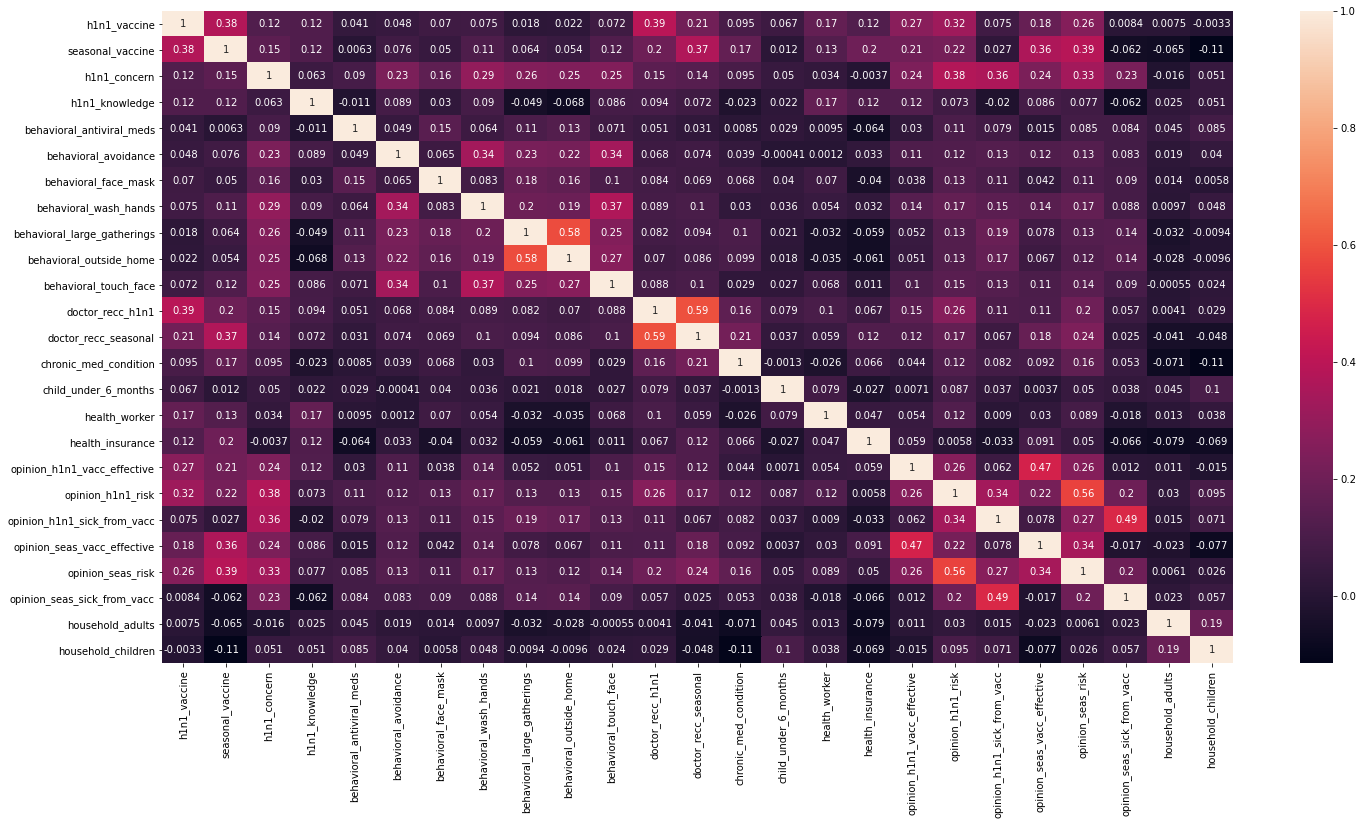

In [181]:
plt.figure(figsize=(24,12))
sns.heatmap(df.iloc[:,1:].corr(), annot=True); # Prelimary heatmap for correlations before transforming all the categorical variables
plt.savefig("corr_heatmap_without_category_transform.svg")

## Drop Certain Null Values

In [101]:
# As health_insurance, employment_industry, employment_occupation have more than 45% of the null values. Drop the NA rows

df_drop = df[["health_insurance", "employment_industry", "employment_occupation"]].dropna()

In [109]:
list(df[df["health_insurance"].isnull()].index) in list(df[df["employment_occupation"].isnull()].index) # The null values does not completely overlap 

False

In [102]:
df_drop.shape # Seems too low

(7353, 3)

In [9]:
df_drop_try = df.dropna(subset=["employment_occupation"]) # Try if could drop backwards

In [131]:
df_drop_try.isnull().sum().sort_values()

respondent_id                     0
census_msa                        0
hhs_geo_region                    0
employment_status                 0
sex                               0
race                              0
age_group                         0
employment_occupation             0
h1n1_vaccine                      0
seasonal_vaccine                  0
child_under_6_months              2
behavioral_face_mask              5
opinion_h1n1_sick_from_vacc       5
opinion_seas_risk                 6
household_children                7
household_adults                  7
opinion_seas_sick_from_vacc       7
health_worker                     8
behavioral_wash_hands            11
opinion_h1n1_risk                12
h1n1_concern                     14
opinion_seas_vacc_effective      16
behavioral_antiviral_meds        21
behavioral_outside_home          22
behavioral_large_gatherings      26
behavioral_touch_face            37
h1n1_knowledge                   39
opinion_h1n1_vacc_effective 

In [132]:
df_drop_try.shape

(13237, 38)

In [133]:
5824/13237 # Null values portion still too high.

0.4399788471708091

In [10]:
df_drop_insurance = df.dropna(subset=["health_insurance"]) # Try dropping from the most statistical significant feature

In [152]:
df_drop_insurance.shape

(14433, 38)

In [121]:
df_drop_insurance.isnull().sum().sort_values()

respondent_id                     0
health_insurance                  0
age_group                         0
race                              0
hhs_geo_region                    0
sex                               0
seasonal_vaccine                  0
h1n1_vaccine                      0
census_msa                        0
child_under_6_months              2
household_adults                  4
household_children                4
opinion_seas_sick_from_vacc       5
opinion_h1n1_sick_from_vacc      10
health_worker                    10
behavioral_face_mask             11
behavioral_wash_hands            18
opinion_seas_risk                23
opinion_h1n1_risk                28
opinion_seas_vacc_effective      30
opinion_h1n1_vacc_effective      45
behavioral_antiviral_meds        47
behavioral_outside_home          49
h1n1_concern                     50
behavioral_large_gatherings      53
behavioral_touch_face            69
h1n1_knowledge                   74
marital_status              

In [123]:
1741/14433

0.12062634240975542

In [11]:
df_drop = df_drop_insurance.dropna(subset=["employment_industry"]) # Create a new dataframe

In [12]:
df_drop = df_drop.dropna(subset=["doctor_recc_seasonal"])  # Same missing values with "doctor_recc_h1n1"

In [153]:
df_drop.isnull().sum().sort_values()

respondent_id                    0
employment_status                0
age_group                        0
employment_industry              0
health_insurance                 0
child_under_6_months             0
hhs_geo_region                   0
race                             0
doctor_recc_h1n1                 0
census_msa                       0
doctor_recc_seasonal             0
sex                              0
household_adults                 0
h1n1_vaccine                     0
household_children               0
seasonal_vaccine                 0
opinion_seas_sick_from_vacc      2
opinion_h1n1_sick_from_vacc      2
behavioral_wash_hands            5
behavioral_face_mask             5
health_worker                    6
opinion_seas_risk                6
opinion_h1n1_risk                8
h1n1_concern                    11
behavioral_outside_home         12
behavioral_antiviral_meds       12
opinion_seas_vacc_effective     13
behavioral_large_gatherings     16
opinion_h1n1_vacc_ef

In [156]:
556/7338

0.07576996456800218

In [13]:
df_drop.shape # Rows to keep

(7338, 38)

In [14]:
df_no_na = df_drop.dropna(subset=["income_poverty"])

In [23]:
df_no_na.isnull().sum().sort_values()

respondent_id                    0
race                             0
employment_status                0
age_group                        0
employment_industry              0
health_insurance                 0
child_under_6_months             0
sex                              0
doctor_recc_seasonal             0
doctor_recc_h1n1                 0
census_msa                       0
hhs_geo_region                   0
income_poverty                   0
h1n1_vaccine                     0
seasonal_vaccine                 0
household_adults                 0
household_children               0
opinion_seas_sick_from_vacc      2
opinion_h1n1_sick_from_vacc      2
opinion_seas_risk                3
behavioral_face_mask             3
behavioral_wash_hands            3
opinion_h1n1_risk                4
health_worker                    6
h1n1_concern                     6
opinion_seas_vacc_effective      8
behavioral_outside_home          9
behavioral_antiviral_meds       11
behavioral_large_gat

In [15]:
df_no_na = df_no_na.dropna(subset=["opinion_seas_sick_from_vacc"])

In [64]:
df_no_na.shape

(6437, 38)

In [63]:
df_no_na.isnull().sum().sort_values()

respondent_id                  0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_children             0
opinion_h1n1_sick_from_vacc    0
opinion_h1n1_risk              0
opinion_h1n1_vacc_effective    0
health_insurance               0
h1n1_vaccine                   0
seasonal_vaccine               0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
employment_industry            0
behavioral_wash_hands          0
behavioral_outside_home        0
behavioral

In [18]:
df_no_na.shape

(6780, 38)

In [195]:
# import pickle

# f = open("data/df", "wb")
# pickle.dump(df, f)
# f.close()

# f = open("data/df_drop", "wb")
# pickle.dump(df_drop, f)
# f.close()

# f = open("data/df_no_na", "wb")
# pickle.dump(df_no_na, f)
# f.close()

In [20]:
import pickle
df.to_pickle("Data/df.pkl")
df_drop.to_pickle("Data/df_drop.pkl")
df_no_na.to_pickle("Data/df_no_na.pkl")

## Frequency Plots

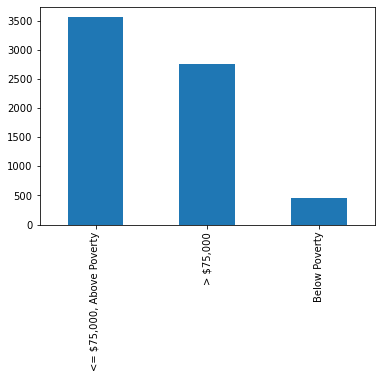

In [169]:
df_drop['income_poverty'].value_counts().plot(kind='bar'); #NA=556

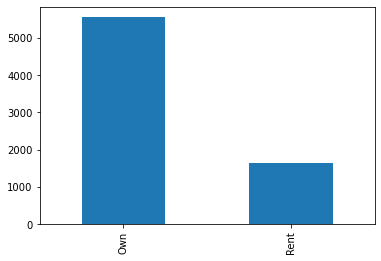

In [170]:
df_drop['rent_or_own'].value_counts().plot(kind='bar'); #NA = 139 

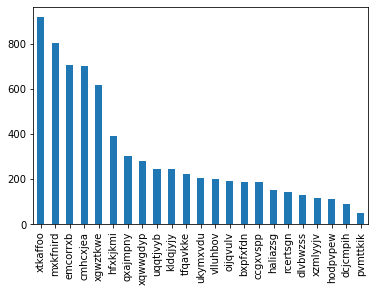

In [171]:
df_drop['employment_occupation'].value_counts().plot(kind='bar');

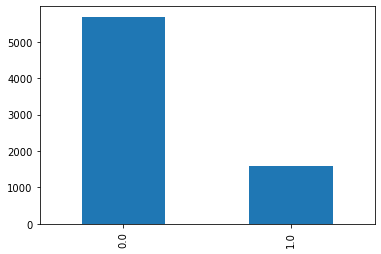

In [172]:
df_drop['chronic_med_condition'].value_counts().plot(kind='bar');

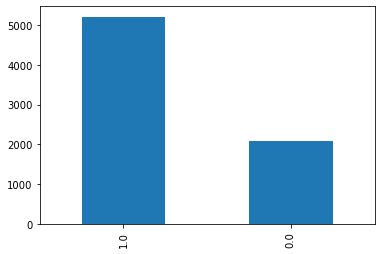

In [173]:
df_drop['behavioral_avoidance'].value_counts().plot(kind='bar');

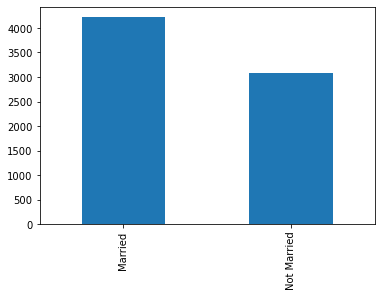

In [174]:
df_drop['marital_status'].value_counts().plot(kind='bar');

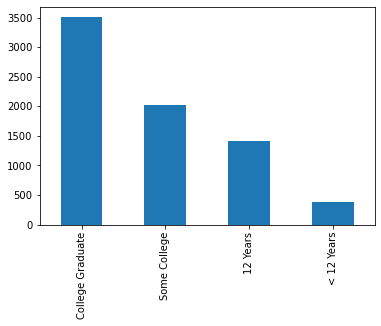

In [175]:
df_drop['education'].value_counts().plot(kind='bar'); 

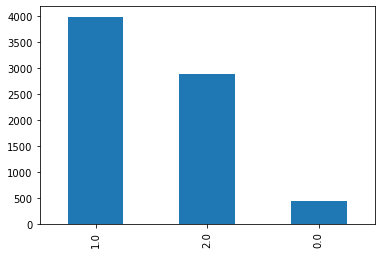

In [176]:
df_drop['h1n1_knowledge'].value_counts().plot(kind='bar'); 

## MICE Imputation

In [195]:
pip install fancyimpute # Getting ready for missing data imputaion 

     |████████████████████████████████| 1.0 MB 1.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 1.8 MB/s eta 0:00:01
  Created wheel for fancyimpute: filename=fancyimpute-0.5.5-py3-none-any.whl size=26455 sha256=96bc82f4890e164a9e657ca38999c612c67d86fb0d06719dec10283dd1fae735
  Stored in directory: /Users/v/Library/Caches/pip/wheels/fc/a1/09/732183800f7c813b6698e5a15bf1b47d52b037ec76d7277aa5
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11354 sha256=e8b94b3718519f84915c8f77f3b30e4d765be02d1aa72dd93990fa960f2d39e8
  Stored in directory: /Users/v/Library/Caches/pip/wheels/5f/e9/7a/9969b4e11eb626b45f12a46849b8c65aa718244a243583caf1
  Created wheel for cvxpy: filename=cvxpy-1.1.6-cp

## Transform Categorical Variables
Trying out One Hot Encoding and Label Encoding

In [182]:
df_na = df_drop.fillna("NA")

In [183]:
df_na.isnull().sum().sort_values()

respondent_id                  0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_children             0
opinion_h1n1_sick_from_vacc    0
opinion_h1n1_risk              0
opinion_h1n1_vacc_effective    0
health_insurance               0
h1n1_vaccine                   0
seasonal_vaccine               0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
employment_industry            0
behavioral_wash_hands          0
behavioral_outside_home        0
behavioral

In [136]:
pip install category_encoders

     |████████████████████████████████| 80 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import category_encoders as ce

In [188]:
df_na = df_na.reset_index(drop=True)

In [189]:
encoder= ce.BinaryEncoder(cols=binary,return_df=True)

In [190]:
df_tsf=encoder.fit_transform(df_na) 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [191]:
df_tsf.shape

(7338, 43)

In [115]:
df_tsf.iloc[:,20:35]

,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex_0,sex_1,income_poverty,marital_status_0,marital_status_1,marital_status_2,rent_or_own_0,rent_or_own_1
0,4,4,2,4,35 - 44 Years,12 Years,White,0,1,Below Poverty,0,0,1,0,0
1,1,4,2,1,45 - 54 Years,Some College,White,1,0,"<= $75,000, Above Poverty",0,1,0,0,1
2,2,5,4,4,45 - 54 Years,12 Years,White,0,1,"<= $75,000, Above Poverty",0,1,0,0,0
3,2,4,2,1,55 - 64 Years,College Graduate,White,0,1,"> $75,000",0,1,0,0,1
4,2,2,1,1,35 - 44 Years,College Graduate,White,1,0,"> $75,000",0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,1,1,1,1,45 - 54 Years,College Graduate,Hispanic,1,0,"<= $75,000, Above Poverty",0,1,0,0,1
7489,4,5,5,4,45 - 54 Years,Some College,White,0,1,NA,0,1,0,0,1
7490,5,5,1,4,45 - 54 Years,Some College,White,1,0,"<= $75,000, Above Poverty",0,1,0,0,1
7491,2,5,1,1,18 - 34 Years,College Graduate,White,0,1,"<= $75,000, Above Poverty",0,0,1,0,0


In [207]:
df_dum = pd.get_dummies(df_na, columns=binary)

In [208]:
df_dum.shape

(7338, 43)

In [119]:
df_dum.iloc[:,20:30]

,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,income_poverty,employment_status,hhs_geo_region
0,4,4,2,4,35 - 44 Years,12 Years,White,Below Poverty,Employed,bhuqouqj
1,1,4,2,1,45 - 54 Years,Some College,White,"<= $75,000, Above Poverty",Employed,bhuqouqj
2,2,5,4,4,45 - 54 Years,12 Years,White,"<= $75,000, Above Poverty",Employed,lzgpxyit
3,2,4,2,1,55 - 64 Years,College Graduate,White,"> $75,000",Employed,oxchjgsf
4,2,2,1,1,35 - 44 Years,College Graduate,White,"> $75,000",Employed,lzgpxyit
...,...,...,...,...,...,...,...,...,...,...
7488,1,1,1,1,45 - 54 Years,College Graduate,Hispanic,"<= $75,000, Above Poverty",Employed,mlyzmhmf
7489,4,5,5,4,45 - 54 Years,Some College,White,NA,Employed,bhuqouqj
7490,5,5,1,4,45 - 54 Years,Some College,White,"<= $75,000, Above Poverty",Employed,qufhixun
7491,2,5,1,1,18 - 34 Years,College Graduate,White,"<= $75,000, Above Poverty",Employed,lzgpxyit


In [186]:
df_dum = df_dum.drop(["sex_Male"],axis = 1)

In [187]:
df_dum.shape

(7338, 42)

In [132]:
df_tsf.isnull().sum().sort_values()

respondent_id                  0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex_0                          0
sex_1                          0
income_poverty                 0
marital_status_0               0
opinion_seas_risk              0
marital_status_1               0
rent_or_own_0                  0
rent_or_own_1                  0
rent_or_own_2                  0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_children             0
marital_status_2               0
employment_industry            0
opinion_seas_vacc_effective    0
opinion_h1n1_risk              0
h1n1_vaccine                   0
seasonal_vaccine               0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral

In [138]:
df_dum.isnull().sum().sort_values() # Keep get_dummy method as labels are clearer for interpretation 

respondent_id                  0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
income_poverty                 0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_children             0
employment_industry            0
employment_occupation          0
sex_Female                     0
marital_status_Married         0
marital_status_NA              0
marital_status_Not Married     0
rent_or_own_NA                 0
opinion_seas_risk              0
opinion_seas_vacc_effective    0
opinion_h1n1_sick_from_vacc    0
opinion_h1n1_risk              0
h1n1_vaccine                   0
seasonal_vaccine               0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
rent_or_ow

In [192]:
df_drop[df_drop["rent_or_own"].isnull()].index

Int64Index([   26,    56,    57,   284,   579,   746,   788,   840,  1179,
             1617,
            ...
            25411, 25530, 25989, 26071, 26288, 26383, 26459, 26543, 26577,
            26620],
           dtype='int64', length=139)

In [193]:
df_dum[df_dum["rent_or_own_NA"]==1].index

Int64Index([   26,    56,    57,   284,   579,   746,   788,   840,  1179,
             1617,
            ...
            25411, 25530, 25989, 26071, 26288, 26383, 26459, 26543, 26577,
            26620],
           dtype='int64', length=139)

In [147]:
labelgroup

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [196]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [225]:
le_age_group = df['age_group'].sort_values().values
le_age_group = le.fit_transform(le_age_group)

In [240]:
df_label = df_drop[labelgroup]

In [241]:
df_label["age_group_le"] = le.fit_transform(df_label["age_group"].values)

<ipython-input-241-782363f868ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label["age_group_le"] = le.fit_transform(df_label["age_group"].values)


In [243]:
df_label['education'] = df_label['education'].astype("|S")
df_label["education_le"] = le.fit_transform(df_label["education"].values)

<ipython-input-243-6a72eb2b2425>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['education'] = df_label['education'].astype("|S")
<ipython-input-243-6a72eb2b2425>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label["education_le"] = le.fit_transform(df_label["education"].values)


In [250]:
df_drop['education']

1                12 Years
7            Some College
10               12 Years
11       College Graduate
15       College Graduate
               ...       
26690    College Graduate
26696        Some College
26699        Some College
26703    College Graduate
26705        Some College
Name: education, Length: 7338, dtype: object

In [256]:
df_label['race'] = df_label['race'].astype("string")
df_label["race_le"] = le.fit_transform(df_label["race"].values)

<ipython-input-256-351a57ce94cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['race'] = df_label['race'].astype("string")
<ipython-input-256-351a57ce94cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label["race_le"] = le.fit_transform(df_label["race"].values)


## MVP

In [158]:
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

#SVM (Support Vector Machine) Classifier

from sklearn.svm import SVC

#Decision Tree

from sklearn.tree import DecisionTreeClassifier

#Random Forest

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

In [389]:
df_drop = df_drop.reset_index(drop = True)

In [186]:
df_trans=df_drop.values

X = df_drop.iloc[:, 3:].astype(str)
y = df_drop.iloc[:, 2].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444)

In [393]:
df_trans=df.values

X = df.iloc[:, 3:].astype(str)
y = df.iloc[:, 2].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444)

In [183]:
df_trans=df_no_na.values

X = df_no_na.iloc[:, 3:].astype(str)
y = df_no_na.iloc[:, 2].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444)

In [187]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [172]:
# one-hot encode input variables
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)
#ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [155]:
# Top 10 features using Randomforrest to predict Seasonal Flu

top_10=[78, 84, 73, 76, 75, 88, 72, 33, 34, 70]
for i in top_10:
    print(X_train.columns[i])

opinion_seas_sick_from_vacc_1.0
age_group_18 - 34 Years
opinion_seas_risk_2.0
opinion_seas_risk_5.0
opinion_seas_risk_4.0
age_group_65+ Years
opinion_seas_risk_1.0
doctor_recc_seasonal_0.0
doctor_recc_seasonal_1.0
opinion_seas_vacc_effective_5.0


In [157]:
# Top 20 features using Randomforrest to predict Seasonal Flu on full dataset

top_20=[37, 124,  57,   7,  31,  52,  46,  54,  69,  67,  78,  84,  73,
        76,  75,  88,  72,  33,  34,  70]
for i in top_20:
    print(X_train.columns[i])

chronic_med_condition_1.0
census_msa_MSA, Not Principle  City
opinion_h1n1_risk_4.0
h1n1_knowledge_2.0
doctor_recc_h1n1_1.0
opinion_h1n1_vacc_effective_5.0
health_insurance_1.0
opinion_h1n1_risk_1.0
opinion_seas_vacc_effective_4.0
opinion_seas_vacc_effective_2.0
opinion_seas_sick_from_vacc_1.0
age_group_18 - 34 Years
opinion_seas_risk_2.0
opinion_seas_risk_5.0
opinion_seas_risk_4.0
age_group_65+ Years
opinion_seas_risk_1.0
doctor_recc_seasonal_0.0
doctor_recc_seasonal_1.0
opinion_seas_vacc_effective_5.0


In [139]:
print(X_train[0][0]) # one hot encode

  (0, 3)	1.0
  (0, 6)	1.0
  (0, 10)	1.0
  (0, 13)	1.0
  (0, 15)	1.0
  (0, 19)	1.0
  (0, 22)	1.0
  (0, 24)	1.0
  (0, 28)	1.0
  (0, 32)	1.0
  (0, 35)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (0, 42)	1.0
  (0, 47)	1.0
  (0, 51)	1.0
  (0, 57)	1.0
  (0, 63)	1.0
  (0, 67)	1.0
  (0, 73)	1.0
  (0, 78)	1.0
  (0, 86)	1.0
  (0, 91)	1.0
  (0, 97)	1.0
  (0, 98)	1.0
  (0, 100)	1.0
  (0, 104)	1.0
  (0, 107)	1.0
  (0, 110)	1.0
  (0, 114)	1.0
  (0, 124)	1.0
  (0, 128)	1.0
  (0, 134)	1.0
  (0, 157)	1.0
  (0, 173)	1.0


Predicting H1N1 Vaccine

In [381]:
#Use the df_drop dataset without seasonal flu as a feature

model = GradientBoostingClassifier(n_estimators=40)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 83.42
roc_auc_score: 76.63


In [378]:
#Use the full df dataset without seasonal flu as a feature

model = GradientBoostingClassifier(n_estimators=40)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 85.09
roc_auc_score: 70.99


In [388]:
#Use the dr_drop dataset with seasonal flu as a feature ------ the best?

model = GradientBoostingClassifier(n_estimators=40)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 84.92
roc_auc_score: 79.71


In [384]:
#Use the full df dataset with seasonal flu as a feature

model = GradientBoostingClassifier(n_estimators=40)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 86.38
roc_auc_score: 74.06


***

Predicting Seasonal Flu vaccine

In [392]:
#Use the df_drop dataset without seasonal flu as a feature

model = GradientBoostingClassifier(n_estimators=40)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 78.70
roc_auc_score: 78.36


In [395]:
#Use the full df dataset without seasonal flu as a feature

model = GradientBoostingClassifier(n_estimators=40)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 78.22
roc_auc_score: 77.92


***

In [166]:
model = SVC()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*model.score(X_test, y_test)))
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))
print(classification_report(y_test, yhat))

Training:  83.69%
Test set:  79.37%
Accuracy_: 79.37
roc_auc_score: 79.07
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4368
           1       0.78      0.76      0.77      3645

    accuracy                           0.79      8013
   macro avg       0.79      0.79      0.79      8013
weighted avg       0.79      0.79      0.79      8013



In [367]:
model = DecisionTreeClassifier()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 76.39
roc_auc_score: 72.13


In [78]:
# Full data set on Seasonal Flu

model = RandomForestClassifier()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*model.score(X_test, y_test)))
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Training: 100.00%
Test set:  78.55%
Accuracy_: 78.55
roc_auc_score: 78.20


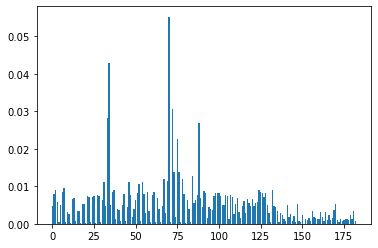

In [79]:
# get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

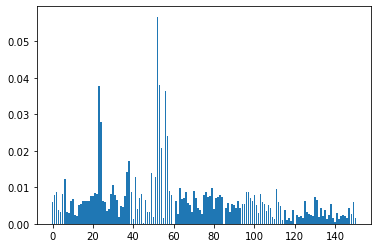

In [174]:
# get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [175]:
indices = np.argsort(importance)[-20:] #Get the index number of the important features
indices

array([ 66,  70,  58, 111,  79,  63,  30,   6,  41,  51,  49,  37,  38,
        54,  57,  24,  56,  23,  53,  52])

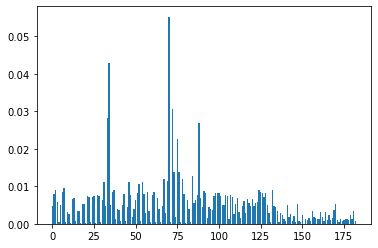

In [79]:
# get importance with dummies
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [147]:
# With dummy variables

model = RandomForestClassifier()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*model.score(X_test, y_test)))
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Training:  99.99%
Test set:  78.34%
Accuracy_: 78.34
roc_auc_score: 78.00


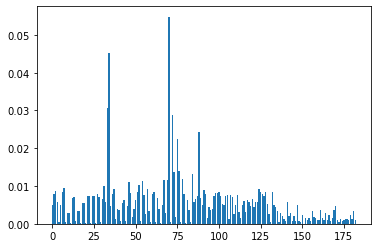

In [148]:
# get importance
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [156]:
indices = np.argsort(importance)[-20:]
indices

array([ 37, 124,  57,   7,  31,  52,  46,  54,  69,  67,  78,  84,  73,
        76,  75,  88,  72,  33,  34,  70])

In [161]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4368
           1       0.77      0.74      0.76      3645

    accuracy                           0.78      8013
   macro avg       0.78      0.78      0.78      8013
weighted avg       0.78      0.78      0.78      8013



In [368]:
model = GaussianNB()
# fit on the training set
model.fit(X_train.todense(), y_train)
# predict on test set
yhat = model.predict(X_test.todense())
# evaluate predictions
accuracy_knn = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 76.39
roc_auc_score: 65.35


In [369]:
model = KNeighborsClassifier(n_neighbors=55)
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Accuracy_: 80.70
roc_auc_score: 71.03


In [91]:
model = CatBoostRegressor()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
# accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*model.score(X_test, y_test)))
# print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Learning rate set to 0.06573
0:	learn: 0.4885386	total: 39.1ms	remaining: 39.1s
1:	learn: 0.4794405	total: 64.9ms	remaining: 32.4s
2:	learn: 0.4710745	total: 85.9ms	remaining: 28.6s
3:	learn: 0.4641931	total: 139ms	remaining: 34.5s
4:	learn: 0.4574107	total: 208ms	remaining: 41.4s
5:	learn: 0.4520841	total: 267ms	remaining: 44.3s
6:	learn: 0.4472973	total: 312ms	remaining: 44.3s
7:	learn: 0.4422682	total: 367ms	remaining: 45.5s
8:	learn: 0.4379713	total: 444ms	remaining: 48.9s
9:	learn: 0.4342382	total: 494ms	remaining: 48.9s
10:	learn: 0.4309089	total: 551ms	remaining: 49.6s
11:	learn: 0.4277409	total: 583ms	remaining: 48s
12:	learn: 0.4250013	total: 658ms	remaining: 50s
13:	learn: 0.4226224	total: 713ms	remaining: 50.2s
14:	learn: 0.4203579	total: 836ms	remaining: 54.9s
15:	learn: 0.4186093	total: 914ms	remaining: 56.2s
16:	learn: 0.4168254	total: 968ms	remaining: 56s
17:	learn: 0.4149341	total: 1.16s	remaining: 1m 3s
18:	learn: 0.4134680	total: 1.25s	remaining: 1m 4s
19:	learn: 0.41

In [138]:
print(importance)

[2.31028326e-01 4.46181822e-01 6.48169962e-01 5.50355095e-01
 8.88096328e-02 6.92696048e-01 5.50652263e-01 1.08953050e+00
 9.77568874e-02 2.25690279e-01 1.23903552e-01 3.48656569e-02
 3.10670572e-01 3.38248420e-01 8.72046430e-02 2.29963884e-01
 1.16670220e-01 1.98676560e-02 2.23173320e-01 3.90875552e-01
 2.57369832e-02 3.94693947e-01 2.79787058e-01 2.57212481e-02
 2.91571333e-01 3.73860734e-01 2.44955431e-02 5.36021207e-01
 3.72729932e-01 5.80383939e-02 6.57585571e-01 6.92416240e-01
 2.07511052e-01 5.51079417e-01 9.06671955e+00 2.55736889e-01
 4.20168144e-01 5.50846895e-01 1.86110231e-01 1.91010055e-01
 3.19603154e-01 0.00000000e+00 6.25252936e-01 1.22039808e+00
 5.31614944e-02 4.21553197e-01 1.61085686e+00 3.97512532e-01
 2.23556466e-01 3.53533188e-01 2.76432704e-01 5.19812170e-01
 9.38448480e-01 8.68079137e-02 1.15815180e+00 4.53454856e-01
 3.95673470e-01 6.51958573e-01 2.35101978e-01 1.12014119e-01
 4.60389748e-01 7.04627949e-01 2.26419462e-02 6.31632314e-01
 4.46391856e-01 1.411135

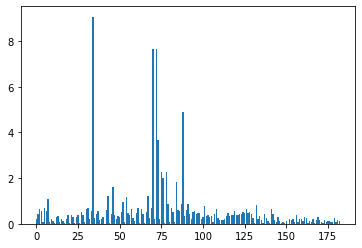

In [100]:
importance = model.get_feature_importance()

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [105]:
indices = np.argsort(importance)[-15:]

In [116]:
indices

array([52,  7, 54, 67, 43, 46, 84, 76, 75, 78, 73, 88, 70, 72, 34])

In [69]:
# define the model
model = LogisticRegression(solver="lbfgs", multi_class="auto")
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
roc_auc = roc_auc_score(y_test, yhat)
print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*model.score(X_test, y_test)))
print('Accuracy_: %.2f' % (accuracy*100))
print('roc_auc_score: %.2f' % (roc_auc*100))

Training:  78.59%
Test set:  78.75%
Accuracy_: 78.75
roc_auc_score: 78.41


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


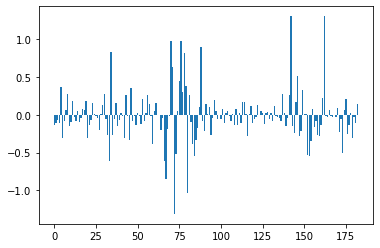

In [76]:
from matplotlib import pyplot
importance = model.coef_[0]
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Confusion Matrix

In [315]:
from sklearn.metrics import confusion_matrix

In [318]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Take Vaccine', 'Not Take Vaccine'],
           yticklabels=['Take Vaccine', 'Not Take Vaccine']);
    plt.xlabel('prediction')
    plt.ylabel('actual')


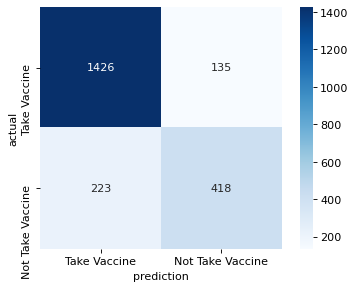

In [319]:
make_confusion_matrix(model)

In [396]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
           xticklabels=['Take Vaccine', 'Not Take Vaccine'],
           yticklabels=['Take Vaccine', 'Not Take Vaccine']);
    plt.xlabel('prediction')
    plt.ylabel('actual')


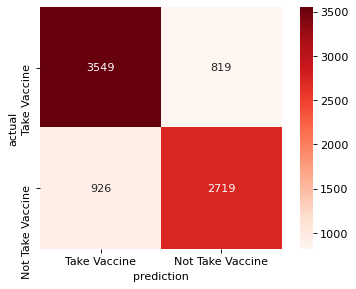

In [397]:
make_confusion_matrix(model)

In [1]:
import numpy 
from catboost import CatBoostRegressor

dataset = numpy.array([[1,4,5,6],[4,5,6,7],[30,40,50,60],[20,15,85,60]])
train_labels = [1.2,3.4,9.5,24.5]
model = CatBoostRegressor(learning_rate=1, depth=6, loss_function='RMSE')
fit_model = model.fit(dataset, train_labels)

print(fit_model.get_params())

0:	learn: 6.8953900	total: 53.2ms	remaining: 53.2s
1:	learn: 4.8590818	total: 54.7ms	remaining: 27.3s
2:	learn: 3.6271477	total: 55.3ms	remaining: 18.4s
3:	learn: 2.7203608	total: 56.8ms	remaining: 14.1s
4:	learn: 2.0402706	total: 57.3ms	remaining: 11.4s
5:	learn: 1.5302029	total: 57.9ms	remaining: 9.6s
6:	learn: 1.1476522	total: 58.5ms	remaining: 8.3s
7:	learn: 0.8607391	total: 59.1ms	remaining: 7.33s
8:	learn: 0.6455544	total: 59.6ms	remaining: 6.56s
9:	learn: 0.4841658	total: 60ms	remaining: 5.94s
10:	learn: 0.3631243	total: 60.5ms	remaining: 5.44s
11:	learn: 0.2723432	total: 61ms	remaining: 5.02s
12:	learn: 0.2042574	total: 61.4ms	remaining: 4.66s
13:	learn: 0.1531931	total: 61.9ms	remaining: 4.36s
14:	learn: 0.1148948	total: 62.6ms	remaining: 4.11s
15:	learn: 0.0861711	total: 63.1ms	remaining: 3.88s
16:	learn: 0.0646283	total: 64.5ms	remaining: 3.73s
17:	learn: 0.0484712	total: 65.1ms	remaining: 3.55s
18:	learn: 0.0363534	total: 65.7ms	remaining: 3.39s
19:	learn: 0.0272651	total: 